# Importing Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Loading the Datasets

In [2]:
dataset_path = "datasets/"
df_customers = pd.read_csv(dataset_path + "olist_customers_dataset.csv")
df_orders = pd.read_csv(dataset_path + "olist_orders_dataset.csv")
df_order_items = pd.read_csv(dataset_path + "olist_order_items_dataset.csv")
df_products = pd.read_csv(dataset_path + "olist_products_dataset.csv")
df_category_name_translation = pd.read_csv(dataset_path + "product_category_name_translation.csv")
df_order_payments = pd.read_csv(dataset_path + "olist_order_payments_dataset.csv")

Create SQL engine using sqlite3, & then convert pd dataframes into SQL tables

In [3]:
from sqlalchemy import create_engine
engine = create_engine("sqlite://", echo=False)

In [4]:
df_customers.to_sql("Customers", con=engine)
df_orders.to_sql("Orders", con=engine)
df_order_items.to_sql("order_items", con=engine)
df_products.to_sql("Products", con=engine)
df_category_name_translation.to_sql("category_name", con=engine)
df_order_payments.to_sql("Payments", con=engine)

103886

In [5]:
def run_query(command):
    return pd.read_sql_query(command,con=engine)

# In Depth Data Analysis

Customer and Sales Analysis
1. How many unique cities and states are present?
2. Which state has the highest order count?
3. Which city has the highest order count?
4. What are their purchase trends? (hourly/daily/weekly/monthly)

In [6]:
# city count
sql = '''
SELECT COUNT(DISTINCT customer_city) AS city_count
FROM customers 
'''

In [7]:
city_count = run_query(sql)
city_count

,city_count
0,4119


In [8]:
# state count
sql = '''
SELECT COUNT(DISTINCT customer_state) AS state_count
FROM customers 
'''

In [9]:
run_query(sql)

,state_count
0,27


In [10]:
sql = '''
SELECT c.customer_city AS city,  
        COUNT(o.customer_id) as customer_count
FROM orders o
LEFT JOIN customers c
ON o.customer_id = c.customer_id
GROUP BY city
ORDER BY customer_count DESC
LIMIT 20
''';

city_rank_sql = run_query(sql)

In [11]:
city_rank_sql

,city,customer_count
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


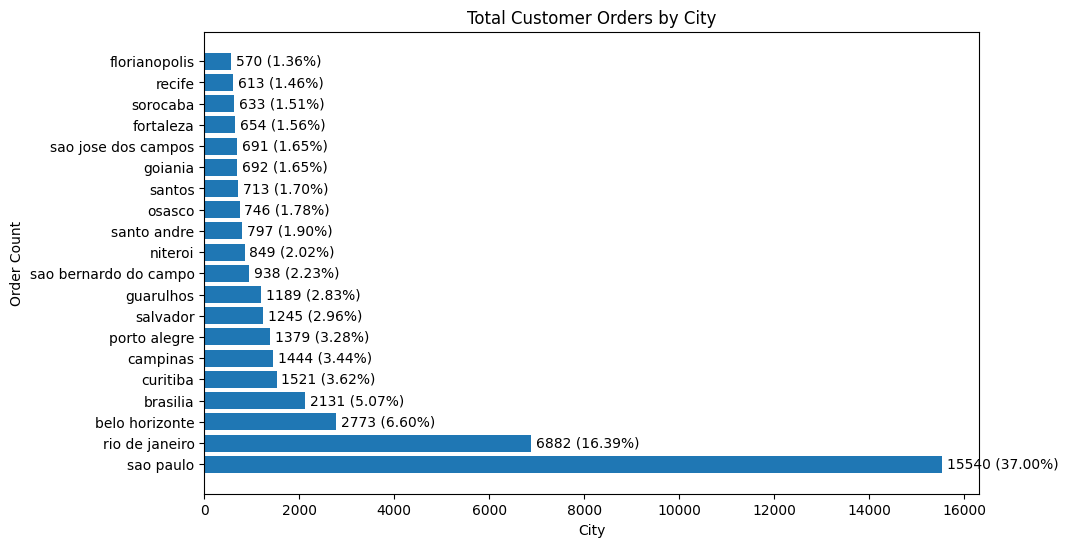

In [82]:
plt.figure(figsize=(10, 6))
bars = plt.barh(city_rank_sql['city'], city_rank_sql['customer_count'])
plt.title('Total Customer Orders by City')
plt.xlabel('City')
plt.ylabel('Order Count')

text_distance = 100
for bar, count in zip(bars, city_rank_sql['customer_count']):
    plt.text(count + text_distance, bar.get_y() + bar.get_height()/2, f'{count} ({count / sum(city_rank_sql["customer_count"]) * 100:.2f}%)', 
             va='center', ha='left')

plt.show()

In [12]:
sql = '''
SELECT c.customer_state AS state,  
        COUNT(o.customer_id) as customer_count
FROM orders o
LEFT JOIN customers c
ON o.customer_id = c.customer_id
GROUP BY state 
ORDER BY customer_count DESC
LIMIT 10
''';

state_rank_sql = run_query(sql)

In [13]:
state_rank_sql

,state,customer_count
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


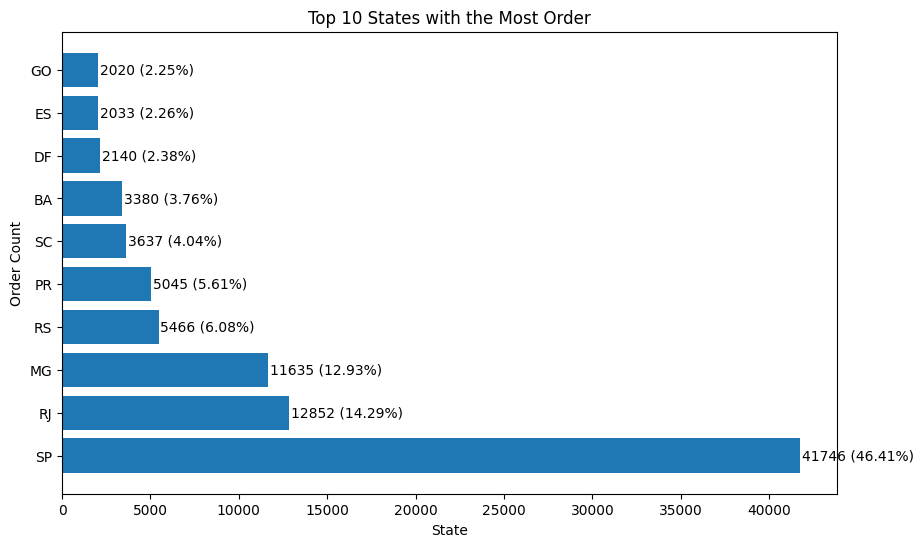

In [83]:
plt.figure(figsize=(10, 6))
bars = plt.barh(state_rank_sql['state'], state_rank_sql['customer_count'])
plt.title('Top 10 States with the Most Order')
plt.xlabel('State')
plt.ylabel('Order Count')

text_distance = 100
for bar, count in zip(bars, state_rank_sql['customer_count']):
    plt.text(count + text_distance, bar.get_y() + bar.get_height()/2, f'{count} ({count / sum(state_rank_sql["customer_count"]) * 100:.2f}%)', 
             va='center', ha='left')

plt.show()

- Analyze order count based on hour of day, day of week & monthly purchase trend.
- Feature engineering is performed to extract hour, day, month and year from the original timestamp.

In [14]:
cte_sql = '''
WITH cleaned_order AS (
        SELECT 
                order_id,
                order_purchase_timestamp,
                -- cast type as integer to remove leading zero
                CAST(strftime('%Y', order_purchase_timestamp) AS INT) AS Year,
                CAST(strftime('%m', order_purchase_timestamp) AS INT) AS Month,
                CAST(strftime('%w', order_purchase_timestamp) AS INT) AS Day,
                CAST(strftime('%H', order_purchase_timestamp) AS INT) AS Hour
        FROM orders
        WHERE Year = 2017
)
'''
month_sql = cte_sql + '''
SELECT 
        CASE month
                WHEN 1 THEN 'JAN'
                WHEN 2 THEN 'FEB'
                WHEN 3 THEN 'MAR'
                WHEN 4 THEN 'APR'
                WHEN 5 THEN 'MAY'
                WHEN 6 THEN 'JUN'
                WHEN 7 THEN 'JUL'
                WHEN 8 THEN 'AUG'
                WHEN 9 THEN 'SEP'
                WHEN 10 THEN 'OCT'
                WHEN 11 THEN 'NOV'
                WHEN 12 THEN 'DEC'
        END AS Month,
        Year,
        COUNT(*) as order_count
FROM cleaned_order
GROUP BY Year, Month
'''

In [15]:
month_data = run_query(month_sql)

In [16]:
month_data

,Month,Year,order_count
0,JAN,2017,800
1,FEB,2017,1780
2,MAR,2017,2682
3,APR,2017,2404
4,MAY,2017,3700
5,JUN,2017,3245
6,JUL,2017,4026
7,AUG,2017,4331
8,SEP,2017,4285
9,OCT,2017,4631


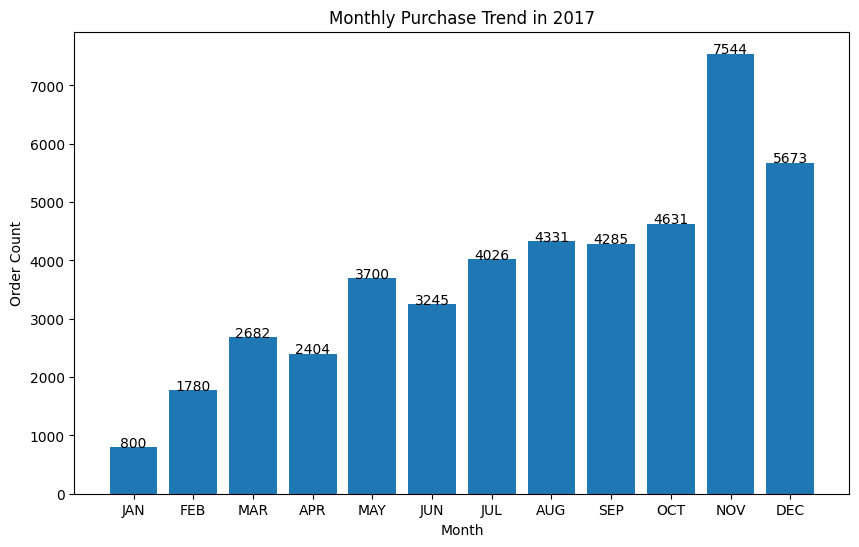

In [93]:
plt.figure(figsize=(10, 6))
bars = plt.bar(month_data['Month'], month_data["order_count"])
plt.title('Monthly Purchase Trend in 2017')
plt.xlabel('Month')
plt.ylabel('Order Count')

for bar, count in zip(bars, month_data['order_count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center')

plt.show()

In [17]:
day_sql = cte_sql + '''
SELECT 
  CASE Day
    WHEN 0 THEN 'SUN'
    WHEN 1 THEN 'MON'
    WHEN 2 THEN 'TUE'
    WHEN 3 THEN 'WED'
    WHEN 4 THEN 'THU'
    WHEN 5 THEN 'FRI'
    WHEN 6 THEN 'SAT'
  END AS Day,
  COUNT(*) AS order_count
FROM cleaned_order
GROUP BY Day
'''

In [18]:
day_data = run_query(day_sql)

In [19]:
day_data

,Day,order_count
0,SUN,5486
1,MON,7188
2,TUE,7170
3,WED,6775
4,THU,6516
5,FRI,6915
6,SAT,5051


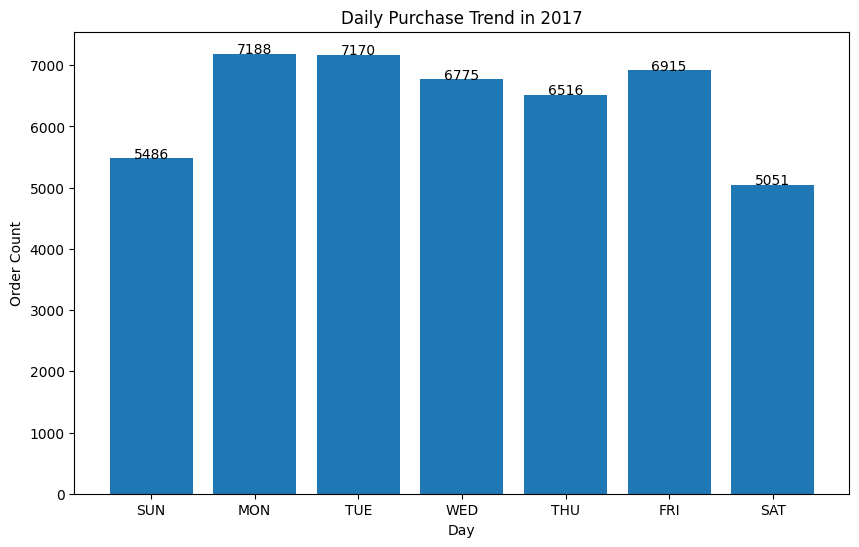

In [106]:
plt.figure(figsize=(10, 6))
bars = plt.bar(day_data['Day'], day_data["order_count"])
plt.title('Daily Purchase Trend in 2017')
plt.xlabel('Day')
plt.ylabel('Order Count')

for bar, count in zip(bars, day_data['order_count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center')

plt.show()

In [20]:
hour_sql = cte_sql + '''
SELECT 
  hour, 
  COUNT(*) AS order_count
FROM cleaned_order
GROUP BY hour
'''

In [21]:
hour_data = run_query(hour_sql)

In [22]:
hour_data

,Hour,order_count
0,0,1157
1,1,595
2,2,261
3,3,128
4,4,104
5,5,95
6,6,216
7,7,529
8,8,1280
9,9,2058


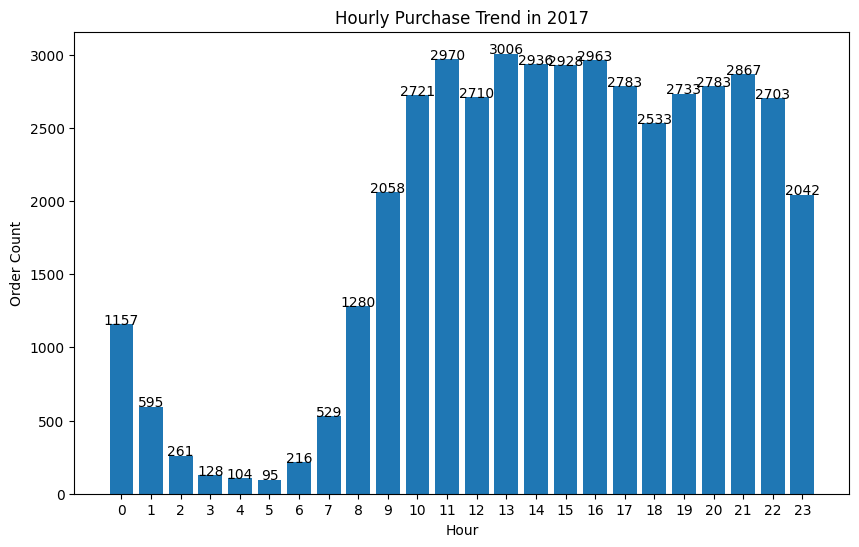

In [111]:
plt.figure(figsize=(10, 6))
bars = plt.bar(hour_data['Hour'], hour_data["order_count"])
plt.title('Hourly Purchase Trend in 2017')
plt.xlabel('Hour')
plt.ylabel('Order Count')
plt.xticks(hour_data['Hour'])

for bar, count in zip(bars, hour_data['order_count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center')

plt.show()

# Product Analysis

- How many unique product lines?
- What are the most popular categories?

In [22]:
# number of product category
sql = '''
SELECT COUNT(DISTINCT product_category_name) as number_of_product_category
FROM products
'''

In [23]:
run_query(sql)

,number_of_product_category
0,73


In [23]:
category_rank_sql = '''
WITH cte AS (
    SELECT 
        o.order_id,
        CAST(strftime('%Y', o.order_purchase_timestamp) AS INT) AS Year,
        nt.product_category_name_english AS category
    FROM orders o
    JOIN order_items oi
    ON o.order_id = oi.order_id
    JOIN products p
    ON oi.product_id = p.product_id
    JOIN category_name nt
    ON p.product_category_name = nt.product_category_name
    WHERE Year = 2017
)

SELECT 
    category,
    COUNT(*) AS order_count
FROM cte
GROUP BY category
ORDER BY order_count DESC
LIMIT 10
'''

In [24]:
category_data = run_query(category_rank_sql)

In [137]:
category_data

,category,order_count
0,bed_bath_table,5223
1,furniture_decor,4147
2,sports_leisure,4095
3,health_beauty,3668
4,computers_accessories,3098
5,housewares,2906
6,toys,2602
7,garden_tools,2463
8,cool_stuff,2315
9,watches_gifts,2283


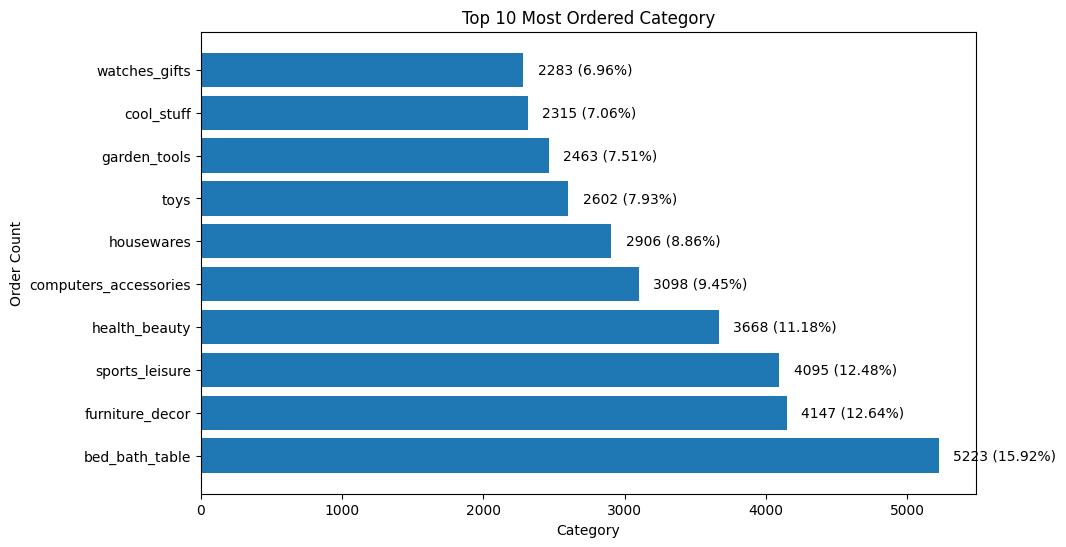

In [139]:
plt.figure(figsize=(10, 6))
bars = plt.barh(category_data['category'], category_data['order_count'])
plt.title('Top 10 Most Ordered Category')
plt.xlabel('Category')
plt.ylabel('Order Count')

text_distance = 100
for bar, count in zip(bars, category_data['order_count']):
    plt.text(count + text_distance, bar.get_y() + bar.get_height()/2, f'{count} ({count / sum(category_data["order_count"]) * 100:.2f}%)', 
             va='center', ha='left')

plt.show()

# Payment Analysis

- How many unique payment methods?
- What are the preferred payment types?
- Do customers prefer installment plans?

In [24]:
# number of payment methods
sql = '''
SELECT COUNT(DISTINCT payment_type) as number_of_payment_type
FROM payments
'''

In [25]:
run_query(sql)

,number_of_payment_type
0,5


In [25]:
payment_sql = '''
SELECT 
    payment_type,
    COUNT(*) AS Count
FROM payments
GROUP BY 1
ORDER BY 2 DESC
'''

In [26]:
payment_data = run_query(payment_sql)

In [27]:
payment_data = payment_data[:-1]

In [28]:
payment_data

,payment_type,Count
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529


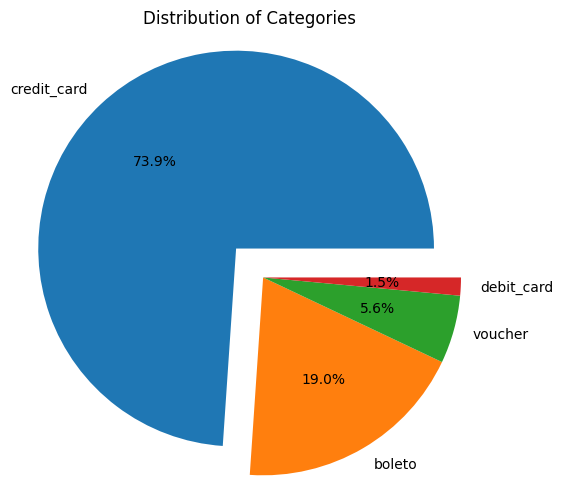

In [161]:
plt.figure(figsize=(6, 6))
plt.pie(payment_data['Count'], labels=payment_data['payment_type'], autopct='%1.1f%%', explode = [0.2, 0, 0, 0])

plt.title('Distribution of Categories')
plt.axis('equal') 

plt.show()

In [29]:
payment_sql = '''
SELECT 
    payment_installments,
    COUNT(*) AS count
FROM payments
GROUP BY 1
ORDER BY 1 
'''

In [173]:
payment_install_data = run_query(payment_sql)

In [181]:
payment_install_data = payment_install_data[1:]

In [183]:
payment_install_data

,payment_installments,count
1,1,52546
2,2,12413
3,3,10461
4,4,7098
5,5,5239
6,6,3920
7,7,1626
8,8,4268
9,9,644
10,10,5328


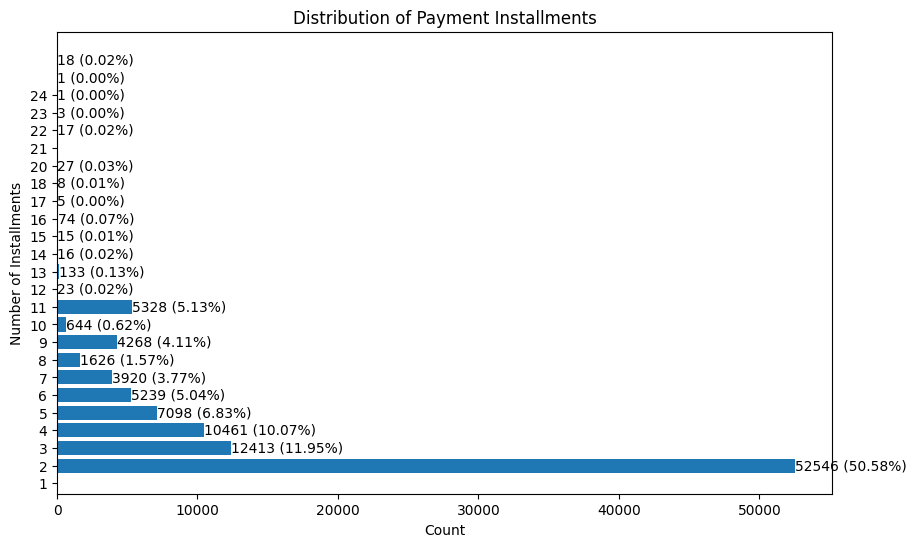

In [184]:
plt.figure(figsize=(10, 6))
bars = plt.barh(payment_install_data['payment_installments'], payment_install_data['count'])
plt.title('Distribution of Payment Installments')
plt.xlabel('Count')
plt.ylabel('Number of Installments')
plt.yticks(range(len(payment_install_data['payment_installments'])), payment_install_data['payment_installments'])

for bar, count in zip(bars, payment_install_data['count']):
    plt.text(count, bar.get_y() + bar.get_height()/2, f'{count} ({count / sum(payment_install_data["count"]) * 100:.2f}%)', 
             va='center', ha='left')

plt.show()